# Regression model for metadata

In [122]:
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt

### Loading the data

In [123]:
y_metrics = pd.read_csv("../../reports/tot_loss_lstm.csv", index_col=0)["normalized_rmse"]
x_metrics = pd.read_csv("../../data/raw/meta_data.csv", index_col=1).iloc[:, 1:]

In [124]:
exog = [
    "fullTimeEmployees",
    "overallRisk", 
    "dividendYield", 
    "marketCap", 
    "shortRatio", 
    "heldPercentInsiders", 
    "heldPercentInstitutions", 
    "numberOfAnalystOpinions"
]
X = x_metrics[exog]

In [125]:
tickers = y_metrics.index
X = X.loc[tickers, :]
X = add_constant(X)

### Some cleaning

In [126]:
X.loc[:, "dividendYield"] = X["dividendYield"].replace(np.nan, 0)
X.loc[:, "numberOfAnalystOpinions"] = X["numberOfAnalystOpinions"].replace(np.nan, 0)
X.loc[:, "overallRisk"] = X["overallRisk"].replace(np.nan, X["overallRisk"].mean())

In [127]:
tickers_to_drop = X.isna().sum(axis=1).astype(bool)
X = X[~tickers_to_drop]
Y = Y[~tickers_to_drop]

In [128]:
# Ensure you have no nan-values
X.isna().sum()

const                      0
fullTimeEmployees          0
overallRisk                0
dividendYield              0
marketCap                  0
shortRatio                 0
heldPercentInsiders        0
heldPercentInstitutions    0
numberOfAnalystOpinions    0
dtype: int64

In [129]:
model = OLS(Y, X)
result = model.fit(cov_type='HC3')
result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 7
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        normalized_rmse   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                 -0.093
Method:                 Least Squares   F-statistic:                    0.2077
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.981
Time:                        09:53:18   Log-Likelihood:                -139.55
No. Observations:                  34   AIC:                             297.1
Df Residuals:                      25   BIC:                             310.8
Df Model:                           8                                         
Covariance Type:                  HC3                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      19.8005     46.153      0.429      0.668     -70.658     110.259
fullTimeEmployees          -0.0004      0.001     -0.768      0.443      -0.001       0.001
overallRisk                -0.8228      0.988     -0.833      0.405      -2.759       1.113
dividendYield            -128.8214    164.944     -0.781      0.435    -452.105     194.462
marketCap                3.067e-10   3.26e-10      0.941      0.347   -3.32e-10    9.45e-10
shortRatio                  1.2872      1.675      0.768      0.442      -1.996       4.571
heldPercentInsiders       -24.9196     71.698     -0.348      0.728    -165.445     115.606
heldPercentInstitutions    -9.7650     49.650     -0.197      0.844    -107.078      87.547
numberOfAnalystOpinions    -1.1107      1.106     -1.004      0.315      -3.279       1.058
==============================================================================
Omnibus:                       42.779   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.655
Skew:                           2.827   Prob(JB):                     9.61e-35
Kurtosis:                      11.866   Cond. No.                     1.34e+12
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.34e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

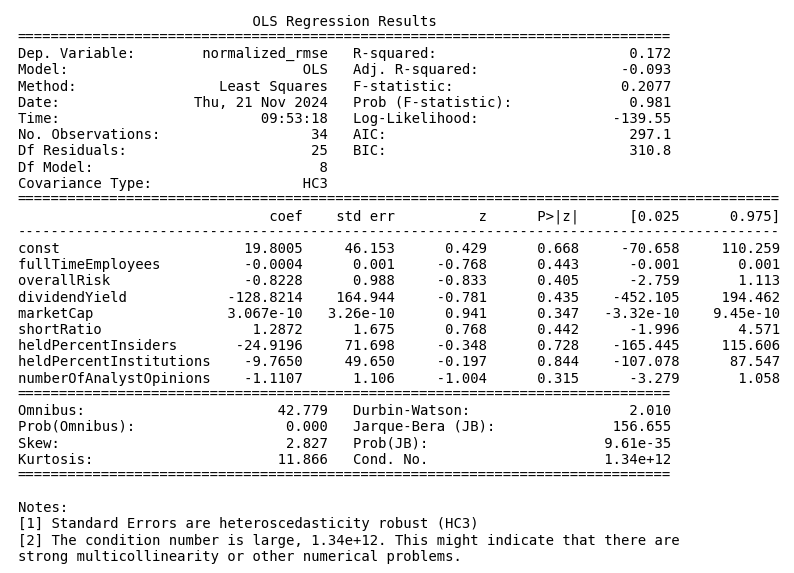

In [ ]:
summary_text = result.summary().as_text()

# Render the summary as a PNG
plt.figure(figsize=(10, 6))
plt.text(0.01, 0.99, summary_text, fontsize=10, family='monospace', verticalalignment='top')
plt.axis('off')

# Save as PNG
plt.savefig("model_summary.png", dpi=300, bbox_inches='tight')
plt.show()